# Gradient boosting with nadaraya watson

In [1]:
# LOAD LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

In [2]:
## load data
data = pd.read_csv('../data/output/final_database.csv')
data.columns

# date as datetime
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.dayofweek

In [3]:

class GradientBoostingNadarayaWatson:
    def __init__(self, num_iterations=100, learning_rate=0.1, bandwidth=None):
        """
        Gradient Boosting with Nadaraya-Watson Kernel
        
        Args:
        - num_iterations (int): Maximum number of boosting iterations.
        - learning_rate (float): Learning rate for boosting updates.
        - bandwidth (float): Bandwidth for the Nadaraya-Watson kernel. If None, it will be calculated automatically.
        """
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.bandwidth = bandwidth
        self.F_pred = None
        self.residuals = None
        self.X_train = None

    def _kernel_function(self, x):
        """Epanechnikov kernel function."""
        return np.where(np.abs(x) <= 1, 1/2, 0)

    def _compute_bandwidth(self, n):
        """Calculate bandwidth based on the sample size."""
        return n ** (-1 / 6)

    def _nadaraya_watson(self, x, residuals, X_exp):
        """
        Apply Nadaraya-Watson regression for a single data point `x`.
        
        Args:
        - x: Single data point (1D array) to predict.
        - residuals: Residual values to fit.
        - X_exp: Training features.
        
        Returns:
        - Prediction at x based on kernel regression.
        """
        h = self.bandwidth or self._compute_bandwidth(len(X_exp))
        
        # Compute pairwise distances and kernel weights for multi-dimensional input
        distances = np.linalg.norm((X_exp - x) / h, axis=1)  # Euclidean distance for multi-dimensions
        weights = self._kernel_function(distances)
        
        numerator = np.sum(residuals * weights)
        denominator = np.sum(weights)
        
        return numerator / denominator if denominator != 0 else 0

    def fit(self, X, y):
        """
        Fit the Gradient Boosting with Nadaraya-Watson model.
        
        Args:
        - X (np.array): Training features.
        - y (np.array): Training target values.
        """
        self.X_train = X  # Store the training features
        self.F_pred = np.mean(y)  # Initialize predictions with the mean of y
        
        for _ in range(self.num_iterations):
            # Step 1: Compute residuals
            self.residuals = y - self.F_pred
            
            # Step 2: Fit residuals using Nadaraya-Watson kernel regression
            res_pred = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in self.X_train])
            
            # Step 3: Update model predictions
            self.F_pred += self.learning_rate * res_pred

    def predict(self, X):
        """
        Predict values using the fitted model.
        
        Args:
        - X (np.array): Features for prediction.
        
        Returns:
        - Predictions for the input features.
        """
        if self.F_pred is None or self.residuals is None or self.X_train is None:
            raise ValueError("Model is not fitted yet. Call `fit` before `predict`.")
        
        # Predict using the retained training residuals and features
        predictions = np.array([self._nadaraya_watson(val, self.residuals, self.X_train) for val in X])
        return predictions


In [4]:
scaler = StandardScaler()

feature_cols = [
                'GDPV', 'IRL', 'IRS', 'GDP', 'CPIH_YTYPCT', 'IRCB', 'UNR',
                'YPH', 'UNR_us',  'CPI_us', 'High_minus_Low', 'Close_minus_Open',
                'SMA_5', 'SMA_10', 'SMA_20', 'WMA_5', 'WMA_10', 'WMA_20', 'Momentum',
                'RSI', 'Williams_R', 'Stochastic_K', 'Stochastic_D', 'CCI', 'MACD',
]

# Select only the columns in `feature_cols` for features
X = data[feature_cols]

# Define the target variable
y = data['Close'].copy()  # Adjust this if your target variable column is named differently
y = y

year = data['Date'].dt.year

X_train =  scaler.fit_transform(X[year < 2023])
X_test = scaler.transform(X[year >= 2023])

y_test = y[year >= 2023].reset_index(drop=True)
y_train = y[year < 2023].reset_index(drop=True)

#Create model
model = GradientBoostingNadarayaWatson(num_iterations=100, learning_rate=0.01)
#Train model
model.fit(X_train, y_train)

In [5]:
# Make predictions on the test set

# Predictions on the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Performance metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r_squared = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5

# # Performance metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r_squared = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5

# Prepare the data for the summary table
summary_table = {
    "Metric": ["R²", "MSE", "RMSE", "MAE"],
    "Train": [train_r_squared, train_mse, train_rmse, train_mae],
    "Test": [test_r_squared, test_mse, test_rmse, test_mae]
}

summary_table = pd.DataFrame(summary_table)
print(summary_table)

  Metric         Train          Test
0     R² -1.911064e+01 -4.902235e+02
1    MSE  2.197250e+07  5.573327e+07
2   RMSE  4.687483e+03  7.465472e+03
3    MAE  4.640956e+03  7.457869e+03


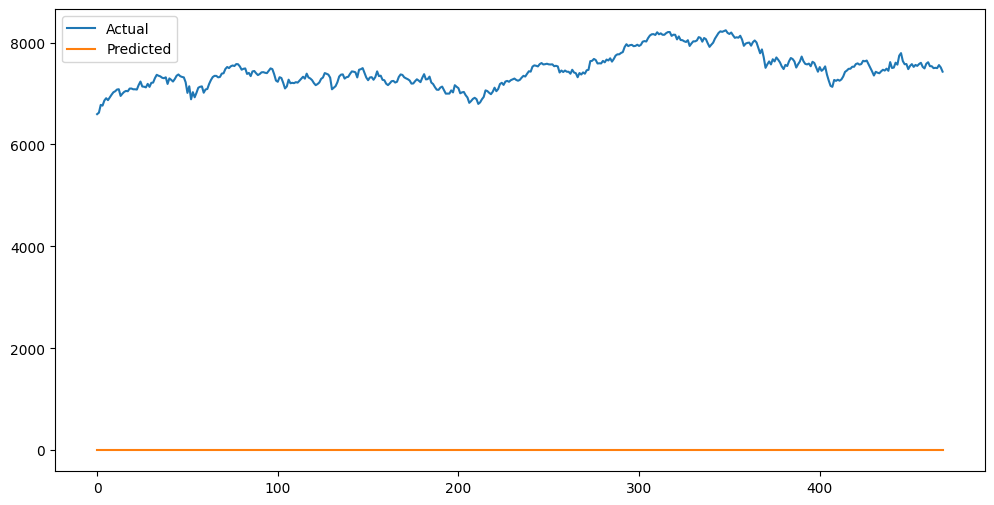

In [6]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.show()
